# Chapter 4 目标检测YOLOv3
- 图像分类的过程是不能直接应用到目标检测上的，因为在图像分类任务中，对整张图提取特征的过程中没能体现出不同目标之间的区别，最终也就没法分别表示出每个物体所在的位置。为了解决这个问题，结合图片分类任务取得的成功经验，我们可以将目标检测任务拆分。假设我们现在有某种方式可以在输入图片上生成一系列可能包含物体的区域(yolov1叫bbox,后面的引入了anchor机制)，然后对每个候选区域，可以单独当成一幅图像来看待，使用图像分类进行分类。
- 
![title](https://img-blog.csdnimg.cn/2019042212202071.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3dlaXhpbl80MjI2OTc3OA==,size_16,color_FFFFFF,t_70)

- RCNN系列检测算法分成两个阶段：在图像上产生候选区域、对候选区域分类并预测目标位置
- SSD和YOLO只使用一个网络同时产生候选区域并预测出位置和类别
- 真实框(ground truth)v其实就是标签
- 预测框(predict box)


In [1]:
#!unzip -q data/data125820/insects.zip
TRAINDIR = 'insects/train'
TESTDIR = 'insects/test'
VALIDDIR = 'insects/val'

ANCHORS = [10,13,16,30,33,23,30,61,62,45,59,119,116,90,156,198,373,326]
INSECT_NAMES = ['red','blue']
NUM_CLASSES = 2

## 1，YOLOv3对于数据的要求

- 文件夹

![title](http://tiebapic.baidu.com/forum/w%3D580/sign=8ce15eed0cda81cb4ee683c56267d0a4/c12c9d58d109b3debd0d527191bf6c81810a4cdf.jpg)

- .xml文件

![title](http://tiebapic.baidu.com/forum/w%3D580/sign=7b2e82525f087bf47dec57e1c2d2575e/46717cf082025aafc2b4c3d2a6edab64024f1a83.jpg)


- 这次我们使用的是百度与北京林业大学合作开发的林业病虫害防治项目中用到昆虫数据集为例，介绍计算机视觉任务中常用的数据预处理方法。
- AI识虫数据集提供了2183张图片，训练集1693张，验证集245张，测试集245张。、
- 包含七种昆虫：Borner，Leconte，Linnaeus，acuminatues，armandi，coleoptera，linnaeus
          
                   
        

In [2]:
#!unzip -q -o data/data19638/insects.zip

# Step1:读取annotations
import os
import numpy as np 
import xml.etree.ElementTree as ET 

def get_insect_names():
    insect_category2id = {}
    global INSECT_NAMES
    for i,item in enumerate(INSECT_NAMES):
        insect_category2id[item] = i
    return insect_category2id

def get_annotations(cname2d,datadir):
    filenames = os.listdir(os.path.join(datadir,'annotations','xmls')) #annotations的位置
    records = []
    ct = 0
    for fname in filenames:
        # 读取一个xml文件
        fid = fname.split('.')[0] # fid存的比如就 ‘1’
        fpath = os.path.join(datadir,'annotations','xmls',fname) # fpath 存的是'insects/train/annotations/xmls/1.xml'
        img_file = os.path.join(datadir,'images',fid+'.jpeg') #img_file 存的是'insects/train/images/1.jpeg'
        tree = ET.parse(fpath) #把xml文件存成tree类
        if tree.find('id') is None:
            im_id = np.array([ct])
        else:
            im_id = np.array([int(tree.find('id').text)])
        
        objs = tree.findall('object')
        im_w = float(tree.find('size').find('width').text)
        im_h = float(tree.find('size').find('height').text)
        gt_bbox = np.zeros((len(objs),4),dtype=np.float32)
        gt_class = np.zeros((len(objs),),dtype=np.int32)
        is_crowd = np.zeros((len(objs),),dtype=np.int32)
        difficult =  np.zeros((len(objs),),dtype=np.int32)

        for i,obj in enumerate(objs):
            cname = obj.find('name').text
            gt_class[i] = cname2cid[cname]
            _difficult = int(obj.find('difficult').text)
            x1 = float(obj.find('bndbox').find('xmin').text)
            y1 = float(obj.find('bndbox').find('ymin').text)
            x2 = float(obj.find('bndbox').find('xmax').text)
            y2 = float(obj.find('bndbox').find('ymax').text)
            x1 = max(0,x1)
            y1 = max(0,y1)
            x2 = min(im_w-1,x2)
            y2 = min(im_h-1,y2)
            gt_bbox[i] = [(x1+x2)/2.0,(y1+y2)/2.0,x2-x1+1,y2-y1+1]
            is_crowd[i] = 0
            difficult[i] = _difficult
        

        voc_rec = {
            'im_file':img_file,
            'im_id':im_id,
            'h':im_h,
            'w':im_w,
            'is_crowd':is_crowd,
            'gt_class':gt_class,
            'gt_bbox':gt_bbox,
            'gt_poly':[],
            'difficult':difficult
        }

        if len(objs) != 0:
                records.append(voc_rec)
        ct += 1
    return records

TRAINDIR = 'insects/train'    
TESTDIR = 'insects/test'
VALIDDIR = 'insects/val'

cname2cid = get_insect_names()
records = get_annotations(cname2cid,TRAINDIR)
#records[0]

        



In [3]:
import cv2
def get_bbox(gt_bbox,gt_class):
    MAX_NUM = 50#一张图片最多有50个框的label，如果多于五十个那俺么多余的直接作废，这个函数就是干这个用的
    gt_bbox2 = np.zeros((MAX_NUM,4))
    gt_class2 = np.zeros((MAX_NUM,))
    for i in range(len(gt_bbox)):
        gt_bbox2[i,:] = gt_bbox[i,:]
        gt_class2[i] = gt_class[i]
        if i > MAX_NUM:
            break
    return gt_bbox2,gt_class2

def get_img_data_from_file(record):
    '''
    record = {
        'im_file':img_file,
        'im_id':im_id,
        'h':im_h,
        'w':im_w,
        'is_crowd':is_crowd,
        'gt_class':gt_class,
        'gt_bbox':gt_bbox,
        'gt_poly':[],
        'difficult':difficult
    }
    '''
    im_file = record['im_file']
    h = record['h']
    w = record['w']
    is_crowd = record['is_crowd']
    gt_class = record['gt_class']
    gt_bbox = record['gt_bbox']
    difficult = record['difficult']

    img = cv2.imread(im_file)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    gt_boxes,gt_labels = get_bbox(gt_bbox,gt_class)

    # !!! 左上角顶点坐标和框的大小要用相对值 !!!
    gt_boxes[:,0] = gt_boxes[:,0]/float(w)
    gt_boxes[:,1] = gt_boxes[:,1]/float(h)
    gt_boxes[:,2] = gt_boxes[:,2]/float(w)
    gt_boxes[:,3] = gt_boxes[:,3]/float(h)

    return img,gt_boxes,gt_labels,(h,w) #返回的是 原图、归一化后的几何四值，类别标签，图片的高度和宽度

#img,gt_boxes,gt_labels,scales = get_img_data_from_file(records[0])
'''
img.shape (1244,1244,3)
gt_boxes.shape (50,4)
gt_labels.shape (50,)
scales = (1244.0,1244.0)
'''      


'\nimg.shape (1244,1244,3)\ngt_boxes.shape (50,4)\ngt_labels.shape (50,)\nscales = (1244.0,1244.0)\n'

#### Step 1 图像预处理(Data Augmentation)
- ImageEnhance.________(img).enhance(e)   
都很好用，但是这些必须对Image类型进行操作
```python
    img = Image.fromarray(img)
    ImageEnhance.Brightness(img).enhance(e)  
    ImageEnhance.Contrast(img).enhance(e)  
    ImageEnhance.Color(img).enhance(e)  
    img = np.asarray(img)
 ```

In [4]:
import numpy as np 
import cv2 
from PIL import Image,ImageEnhance 
import random 

# 1,随机改变亮暗、对比度、颜色
def random_distort(img):
    # (1)随机改变亮度
    def random_brightness(img,lower=0.5,upper=1.5):
        e = np.random.uniform(lower,upper)
        return ImageEnhance.Brightness(img).enhance(e)

    # (2)随机改变对比度
    def random_contrast(img,lower=0.5,upper=1.5):
        e = np.random.uniform(lower,upper)
        return ImageEnhance.Contrast(img).enhance(e)
    
    # (3)随机改变颜色
    def random_color(img,lower=0.5,upper=1.5):
        e = np.random.uniform(lower,upper)
        return ImageEnhance.Color(img).enhance(e)
    
    ops = [random_brightness,random_contrast,random_color]
    np.random.shuffle(ops)

    img = Image.fromarray(img)
    img = ops[0](img) #ImageEnhance很牛批，但是只能对Image对象进行操作，不过我们可以转换
    img = ops[1](img)
    img = ops[2](img)
    img = np.asarray(img) 

    return img

# 2,随机填充
def random_expand(img,gtboxes,max_ratio=4,fill=None,keep_ratio=True,thresh=0.5):
    if random.random() > thresh:
        return img,gtboxes
    if max_ratio < 1.0:
        return img,gtboxes
    h,w,c = img.shape
    ratio_x = random.uniform(1,max_ratio)
    if keep_ratio: #h，w 方向的填充是否一致
        ratio_y = ratio_x
    else:
        ratio_y = random.uniform(1,max_ratio)
    oh = int(h*ratio_y) #填充以后的h
    ow = int(w*ratio_x) #填充以后的y
    off_x = random.randint(0,ow-w) #原图不一定放在正中,h,w方向有(ow-w),(oh-h)的活动范围
    off_y = random.randint(0,oh-h)

    out_img = np.zeros((oh,ow,c))
    if fill and len(fill) == c: #fill是[0,0,255]这样的才行，代表三个通道分别填充啥
        for i in range(c):
            out_img[:,:,i] = fill[i] * 255.0
    
    out_img[off_y:off_y+h,off_x:off_x+w,:] = img
    gtboxes[:,0] = ((gtboxes[:,0]*w)+off_x)/float(ow)
    gtboxes[:,1] = ((gtboxes[:,1]*h)+off_y)/float(oh)
    gtboxes[:,2] = gt_boxes[:,2]/ratio_x
    gtboxes[:,3] = gt_boxes[:,3]/ratio_y

    return out_img.astype('uint8'),gtboxes

# 3,随机裁剪
def random_crop(img,boxes,labels,scales=[0.3,1.0],max_ratio=2.0,constraints=None,max_trial=50):

    def multi_box_iou_xywh(box1,box2):
        assert box1.shape[-1] == 4,"Box1.shape[-1] should be 4"
        assert box2.shape[-1] == 4,"Box2.shape[-1] should be 4"
        b1_x1,b1_x2 = box1[:,0]-box1[:,2]/2,box1[:,0]+box1[:,2]/2
        b1_y1,b1_y2 = box1[:,1]-box1[:,3]/2,box1[:,1]+box1[:,3]/2
        b2_x1,b2_x2 = box2[:,0]-box2[:,2]/2,box2[:,0]+box2[:,2]/2
        b2_y1,b2_y2 = box2[:,1]-box2[:,3]/2,box2[:,1]+box2[:,3]/2

        inter_x1 = np.maximum(b1_x1,b2_x1)
        inter_x2 = np.minimum(b1_x2,b2_x2)
        inter_y1 = np.maximum(b1_y1,b2_y1)
        inter_y2 = np.minimum(b1_y2,b2_y2)
        inter_w = inter_x2 - inter_x1
        inter_h = inter_y2 - inter_y1
        inter_w = np.clip(inter_w,a_min=0.,a_max=None)#所有比零小的数变成零
        inter_h = np.clip(inter_h,a_min=0.,a_max=None)
        
        inter_area = inter_w * inter_h
        b1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
        b2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)

        return inter_area/(b1_area+b2_area-inter_area)

    def box_crop(boxes,labels,crop,img_shape):
        x,y,w,h = map(float,crop) #把第一个函数操作在第二个物体
        im_w,im_h = map(float,img_shape)
        boxes = boxes.copy()
        boxes[:,0],boxes[:,2] = (boxes[:,0] - boxes[:,2]/2)*im_w, (boxes[:,0] + boxes[:,2]/2)*im_w
        boxes[:,1],boxes[:,3] = (boxes[:,1] - boxes[:,3]/2)*im_h, (boxes[:,1] + boxes[:,3]/2)*im_h

        crop_box = np.array([x,y,x+w,y+h])
        centers = (boxes[:,:2]+boxes[:,2:])/2.0
        mask = np.logical_and(crop_box[:2]<=centers,centers<=crop_box[2:]).all(axis=1)

        boxes[:,:2] = np.maximum(boxes[:,:2],crop_box[:2])
        boxes[:,2:] = np.minimum(boxes[:,2:],crop_box[2:])
        boxes[:,:2] -= crop_box[:2]
        boxes[:,2:] -= crop_box[:2]

        mask = np.logical_and(mask,(boxes[:,:2]<boxes[:,2:]).all(axis=1))
        boxes = boxes * np.expand_dims(mask.astype('float32'),axis=1)
        labels = labels * mask.astype('float32')
        boxes[:,0],boxes[:,2] = (boxes[:,0]+boxes[:,2])/2/w, (boxes[:,2]-boxes[:,0])/w
        boxes[:,1],boxes[:,3] = (boxes[:,1]+boxes[:,3])/2/h, (boxes[:,3]-boxes[:,1])/h 

        return boxes,labels,mask.sum()

    #函数内容
    if len(boxes) == 0:
        return img,boxes 
    if not constraints:
        constraints = [(0.1,1.0),(0.3,1.0),(0.5,1.0),(0.7,1.0),(0.9,1.0),(0.0,1.0)]
    img = Image.fromarray(img)
    w,h = img.size
    crops = [(0,0,w,h)]
    for min_iou,max_iou in constraints:
        for _ in range(max_trial):
            scale = random.uniform(scales[0],scales[1])
            aspect_ratio = random.uniform(max(1/max_ratio,scale*scale),min(max_ratio,1/scale/scale))
            crop_h = int(h*scale/np.sqrt(aspect_ratio))
            crop_w = int(w*scale*np.sqrt(aspect_ratio))
            crop_x = random.randrange(w-crop_w)
            crop_y = random.randrange(h-crop_h)
            crop_box = np.array([[(crop_x+crop_w/2.0)/w,(crop_y+crop_h/2.0)/h,crop_w/float(w),crop_h/float(h)]])

            iou = multi_box_iou_xywh(crop_box,boxes)
            if min_iou <= iou.min() and max_iou >= iou.max():
                crops.append((crop_x,crop_y,crop_w,crop_h))
                break
    
    while crops:
        crop = crops.pop(np.random.randint(0,len(crops)))
        crop_boxes,crop_labels,box_num = box_crop(boxes,labels,crop,(w,h))
        if box_num < 1:
            continue
        img = img.crop((crop[0],crop[1],crop[0]+crop[2],crop[1]+crop[3])).resize(img.size,Image.LANCZOS)
        img = np.asarray(img)
        return img,crop_boxes,crop_labels
    img = np.asarray(img)
    return img,boxes,labels

# 4,随机缩放
def random_interp(img,size,interp=None):
    interp_method = [cv2.INTER_NEAREST,cv2.INTER_LINEAR,cv2.INTER_AREA,cv2.INTER_CUBIC,cv2.INTER_LANCZOS4]
    if not interp or interp not in interp_method:
        interp = interp_method[random.randint(0,len(interp_method)-1)]
        h,w,_ = img.shape
        im_scale_x = size/float(w)
        im_scale_y = size/float(h)
        img = cv2.resize(img,None,None,fx=im_scale_x,fy=im_scale_y,interpolation=interp)
    return img

# 5,随机反转
def random_flip(img,gtboxes,thresh=0.5):
    if random.random() > thresh:
        img = img[:,::-1,:]
        gtboxes[:,0] = 1.0 - gtboxes[:,0]
    return img,gtboxes

# 6,随机打乱真实顺序
def shuffle_gtbox(gtbox,gtlabel):
    gt = np.concatenate([gtbox,gtlabel[:,np.newaxis]],axis=1)
    idx = np.arange(gt.shape[0])
    np.random.shuffle(idx)
    gt = gt[idx,:]
    return gt[:,:4],gt[:,4]

# 图像增广的总结函数
def image_augment(img,gtboxes,gtlabels,size,means=None):
    img = random_distort(img)
    img,gtboxes = random_expand(img,gtboxes,fill=means)
    img,gtboxes,gtlabels = random_crop(img,gtboxes,gtlabels)
    img = random_interp(img,size)
    img,gtboxes = random_flip(img,gtboxes)
    gtboxes,gtlabels = shuffle_gtbox(gtboxes,gtlabels)

    return img.astype('float32'),gtboxes.astype('float32'),gtlabels.astype('float32')
size = 512

img,gt_boxes,gt_labels,scales = get_img_data_from_file(records[4])
img,gt_boxes,gt_labels = image_augment(img,gt_boxes,gt_labels,size)
'''
import matplotlib.pyplot as plt
plt.imshow(img.astype('int32'))
plt.show()
'''

def get_img_data(record,size=640):
    img,gt_boxes,gt_labels,scales = get_img_data_from_file(record)
    img,gt_boxes,gt_labels = image_augment(img,gt_boxes,gt_labels,size)
    mean = [0.485,0.456,0.406]
    std = [0.229,0.224,0.225]
    mean = np.array(mean).reshape((1,1,-1))
    std = np.array(std).reshape((1,1,-1))
    img = (img/255.0-mean)/std
    img = img.astype('float32').transpose((2,0,1))
    return img,gt_boxes,gt_labels,scales #返回的是归一化以后的img

'''
cname2cid = get_insect_names()
records = get_annotations(cname2cid,TRAINDIR)
'''
# 批量读取数据与加速
def get_img_size(mode):
    if (mode == 'train') or (mode == 'valid'):
        inds = np.array([0,1,2,3,4,5,6,7,8,9])
        ii = np.random.choice(inds)
        img_size = 320 + ii * 32
    else:
        img_size = 608
    return img_size

# 将List形式的batch数据转化成多个array构成的tuple
def make_array(batch_data):
    img_array = np.array([item[0] for item in batch_data],dtype='float32')
    gt_box_array = np.array([item[1] for item in batch_data],dtype='float32')
    gt_labels_array = np.array([item[2] for item in batch_data],dtype='int32')
    img_scale = np.array([item[3] for item in batch_data],dtype='int32')
    return img_array,gt_box_array,gt_labels_array,img_scale

def data_loader(datadir,batch_size=10,mode='train'):
    cname2cid = get_insect_names()
    records = get_annotations(cname2cid,datadir)
    
    def reader():
        if mode == 'train':
            np.random.shuffle(records)
        batch_data = []
        img_size = get_img_size(mode)

        for record in records:
            img,gt_bbox,gt_labels,im_shape = get_img_data(record,size=img_size)
            batch_data.append((img,gt_bbox,gt_labels,im_shape))
            if len(batch_data) == batch_size:
                yield make_array(batch_data)
                batch_data = []
                img_size = get_img_size(mode)
        if len(batch_data) > 0:
            yield make_array(batch_data)
        
    return reader
'''
d = data_loader(TRAINDIR,batch_size=2,mode='train')
img,gt_boxes_copy,gt_labels,im_shape = next(d())
img.shape,gt_boxes_copy.shape,gt_labels.shape,im_shape.shape
'''

# 一般数据处理时间较长，会成为训练时间的瓶颈，通过使用paddle提供的API(paddle.reader.xmap_readers)可以开启多线程读取数据
import functools
import paddle

def multithread_loader(datadir,batch_size=10,mode='train'):
    cname2cid = get_insect_names()
    records = get_annotations(cname2cid,datadir)#label的字典数组
    
    def reader():
        if mode == 'train':
            np.random.shuffle(records) 
        img_size = get_img_size(mode)
        batch_data = []
        for record in records:
            batch_data.append((record,img_size))
            if len(batch_data) == batch_size:
                yield batch_data
                batch_data = []
                img_size = get_img_size(mode)
        if len(batch_data) > 0:
            yield batch_data
    
    def get_data(samples):
        batch_data = []
        for sample in samples:
            record = sample[0]
            img_size = sample[1]
            img,gt_bbox,gt_labels,im_shape = get_img_data(record,size=img_size)
            batch_data.append((img,gt_bbox,gt_labels,im_shape))
        return make_array(batch_data)
    mapper = functools.partial(get_data,)
    return paddle.reader.xmap_readers(mapper,reader,8,10) 

#d = multithread_loader(TRAINDIR,batch_size=5,mode='train')
#img,gt_boxes_cp,gt_labels_cp,im_shape = next(d())
# 至此，我们完成了查看数据，从xml中提取label，从文件读取图像和标注数据，数据增强，批量读取数据和加速等过程

# 测试数据没有label，也不需要做增广
def make_test_array(batch_data):
    img_name_array = np.array([item[0] for item in batch_data])
    img_data_array = np.array([item[1] for item in batch_data],dtype='float32')
    img_scale_array = np.array([item[2] for item in batch_data],dtype='int32')
    return img_name_array,img_data_array,img_scale_array

def test_data_loader(datadir,batch_size=10,test_image_size=608,mode='test'):
    image_names = os.listdir(datadir)
    def reader():
        batch_data = []
        img_size = test_image_size
        for image_name in image_names:
            file_path = os.path.join(datadir,image_name)
            img = cv2.imread(file_path)
            #print(file_path)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            H,W,_ = img.shape
            img = cv2.resize(img,(img_size,img_size))

            mean = [0.485,0.456,0.406]
            std = [0.229,0.224,0.225]
            out_img = (img/255.0-mean)/std
            out_img = out_img.astype('float32').transpose((2,0,1))
            img = out_img
            im_shape = [H,W]

            batch_data.append((image_name.split('.')[0],img,im_shape))
            if len(batch_data) == batch_size:
                yield make_test_array(batch_data)
                batch_data = []
        if len(batch_data) > 0:
            yield make_test_array(batch_data)
    
    return reader

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/utils.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def convert_to_list(value, n, name, dtype=np.int):


#### Step 2 手撕YOLOv3
- 锚框(anchor)的位置都是固定好的，需要在锚框的基础上进行位置的微调以生成预测框。
- 
例如：
$$第10行第四列的gridcell的左上角坐标被我们记作( c_{x}=4,c_{y}=10)$$
$$ b_{x} = c_{x} + sigmoid(t_{x})$$$$ b_{y} = c_{y} + sigmoid(t_{y})$$

$$锚框的大小是提前预设好的，比如 (p_{h} = 350,p_{w} = 250)$$
$$ b_{h} = p_{h} \times e^{t_{h}}   $$
$$ b_{w} = p_{w} \times e^{t_{w}}$$

- $$网络输出的就是 t_{x},t_{y},t_{h},t_{w}$$

- 计算损失函数时候，我们把一个gridceell的三个anchor中与ground truth的IOU最大的objectness设为1，剩下两个的看阈值范围设置成0(代表负样本，参与损失函数的计算)，-1(不参与损失函数的计算)


 
 



### Step 2.1 标注锚框(location)

- img:输入的图片[N,C,H,W] 那才好哇  
 gt_boxes:真实框，[N,50,4]  
 gt_labels:真实框的类别，维度是[N,50] 

![title](http://tiebapic.baidu.com/forum/w%3D580/sign=08e287fcf06eddc426e7b4f309dbb6a2/9e41d254564e9258d71f2ff7c182d158ccbf4e66.jpg)

In [5]:
 # 下面的程序负责对于所有的anchor进行标记，如果IOU小于某个值设置为-1(负样本)，其余的设置为0.
def get_objectness_label(img,gt_boxes,gt_labels,iou_threshold=0.7,anchors=[116,90,156,198,373,326],num_classes=NUM_CLASSES,downsample=32):
    img_shape = img.shape
    batch_size = img_shape[0] #这里img的大小是 [N,C,H,W]
    num_anchors = len(anchors)//2#x,y坐标，所以要//2
    input_h = img_shape[2]
    input_w = img_shape[3]
    #将输入的图片分成num_rows * num_cols 个 gridcell 每个gricell的边长是 downsample
    num_rows = input_h // downsample
    num_cols = input_w // downsample

    label_objectness = np.zeros([batch_size,num_anchors,num_rows,num_cols])
    label_classification = np.zeros([batch_size,num_anchors,num_classes,num_rows,num_cols])
    label_location = np.zeros([batch_size,num_anchors,4,num_rows,num_cols])
    scale_location = np.zeros([batch_size,num_anchors,num_rows,num_cols])

    def box_iou_xywh(bbox1,bbox2):
        bbox1_square = bbox1[3]*bbox1[2] 
        bbox2_square = bbox2[3]*bbox2[2] 
        and_square = min(bbox1[3],bbox2[3]) * min(bbox1[2],bbox2[2])
        return and_square/(bbox1_square + bbox2_square - and_square)
    # 对batch_size进行循环，依次处理每张图片
    for n in range(batch_size):
        for n_gt in range(len(gt_boxes[n])): #gt_boxes.shape = [N,50,4]
            gt = gt_boxes[n][n_gt]
            gt_cls = gt_labels[n][n_gt]
            gt_center_x = gt[0]
            gt_center_y = gt[1]
            gt_width = gt[2]
            gt_height = gt[3]
            if (gt_height<1e-3) or (gt_height<1e-3):
                continue
            i = int(gt_center_y*num_rows) #真实框位于i,j个gridcell中
            j = int(gt_center_x*num_cols)
            ious = []
            for ka in range(num_anchors):
                bbox1 = [0.,0.,float(gt_width),float(gt_height)]
                anchor_w = anchors[ka*2]
                anchor_h = anchors[ka*2+1]
                bbox2 = [0.,0.,anchor_w/float(input_w),anchor_h/float(input_h)]
                # 计算IOU
                iou = box_iou_xywh(bbox1,bbox2)
                ious.append(iou)
            ious = np.array(ious)
            inds = np.argsort(ious)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
            k = inds[-1]
            label_objectness[n,k,i,j] = 1
            c = gt_cls
            label_classification[n,k,c,i,j] = 1

            dx_label = gt_center_x * num_cols - j
            dy_label = gt_center_y * num_rows - i
            dw_label = np.log(gt_width*input_w/anchors[k*2])
            dh_label = np.log(gt_height*input_h/anchors[k*2+1])
            label_location[n,k,0,i,j] = dx_label
            label_location[n,k,1,i,j] = dy_label
            label_location[n,k,2,i,j] = dw_label
            label_location[n,k,3,i,j] = dh_label
            #scale_location用来调整不同尺寸的锚框对损失函数的贡献，作为加权系数和位置损失函数相乘
            scale_location[n,k,i,j] = 2.0 - gt_width * gt_height
        
    return label_objectness.astype('float32'),label_location.astype('float32'),label_classification.astype('float32'),scale_location.astype('float32')
'''
reader = multithread_loader('insects/train')
img_cp,gt_boxes_cp,gt_labels_cp,im_shape_cp = next(reader())

label_objectness_cp,label_location_cp,label_classification_cp,scale_location_cp = get_objectness_label(img_cp,gt_boxes_cp,gt_labels_cp,iou_threshold=0.7,anchors=[116,90,156,198,373,326],num_classes=7,downsample=32)            

img.shape,gt_boxes.shape,gt_labels.shape,im_shape.shape
'''

"\nreader = multithread_loader('insects/train')\nimg_cp,gt_boxes_cp,gt_labels_cp,im_shape_cp = next(reader())\n\nlabel_objectness_cp,label_location_cp,label_classification_cp,scale_location_cp = get_objectness_label(img_cp,gt_boxes_cp,gt_labels_cp,iou_threshold=0.7,anchors=[116,90,156,198,373,326],num_classes=7,downsample=32)            \n\nimg.shape,gt_boxes.shape,gt_labels.shape,im_shape.shape\n"

### Step 2.2 图形特征提取(Backbone:Darknet53)
![title](https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fpic4.zhimg.com%2Fv2-8959d1c826b11845c12c0fa8bd642ffb_b.jpg&refer=http%3A%2F%2Fpic4.zhimg.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1644675570&t=e33160f226423b60f3f9c4a0aa4b12bd)
- 遇到not implement error很可能是__init__或者forward打字错误


In [6]:
import paddle.fluid as fluid
from paddle.fluid.param_attr import ParamAttr
from paddle.fluid.regularizer import L2Decay
from paddle.fluid.dygraph.nn import Conv2D,BatchNorm
from paddle.fluid.dygraph.base import to_variable

class ConvBNLayer(fluid.dygraph.Layer):
    def __init__(self,ch_in,ch_out,filter_size=3,stride=1,groups=1,padding=0,act='leaky',is_test=True):
        super(ConvBNLayer,self).__init__()
        self.conv = Conv2D(num_channels=ch_in,num_filters=ch_out,filter_size=filter_size,stride=stride,padding=padding,groups=groups,
                           param_attr = ParamAttr(initializer=fluid.initializer.Normal(0.,0.02)),
                           bias_attr = False,
                           act = None)
        
        self.batch_norm = BatchNorm(num_channels=ch_out,is_test=is_test,
                                    param_attr=  ParamAttr(initializer=fluid.initializer.Normal(0.,0.02),regularizer=L2Decay(0.)),
                                    bias_attr = ParamAttr(initializer=fluid.initializer.Constant(0.0),regularizer=L2Decay(0.))
                            )
        self.act = act
    def forward(self,inputs):
        out = self.conv(inputs)
        out = self.batch_norm(out)
        if self.act == 'leaky':
            out = fluid.layers.leaky_relu(x=out,alpha=0.1)
        return out

# 下采样，图片尺寸裁剪，使用stride=2的卷积
class DownSample(fluid.dygraph.Layer):
    def __init__(self,ch_in,ch_out,filter_size=3,stride=2,padding=1,is_test=True):
        super(DownSample,self).__init__()
        self.conv_bn_layer = ConvBNLayer(ch_in=ch_in,ch_out=ch_out,filter_size=filter_size,stride=stride,padding=padding,is_test=is_test)
        self.ch_out = ch_out
    def forward(self,inputs):
        out = self.conv_bn_layer(inputs)
        return out

# 基本残差块的定义，输入x经过两层卷积，然后接第二层卷积的输出和输入x相加
class BasicBlock(fluid.dygraph.Layer):
    def __init__(self,ch_in,ch_out,is_test=True):
        super(BasicBlock,self).__init__()

        self.conv1 = ConvBNLayer(ch_in=ch_in,ch_out=ch_out,filter_size=1,stride=1,padding=0,is_test=is_test)
        self.conv2 = ConvBNLayer(ch_in=ch_out,ch_out=ch_out*2,filter_size=3,stride=1,padding=1,is_test=is_test)

    def forward(self,inputs):
        conv1 = self.conv1(inputs)
        conv2 = self.conv2(conv1)
        out = fluid.layers.elementwise_add(x=inputs,y=conv2,act=None)
        return out

# 添加多层残差块，组成darknet53网络的一个层级
class LayerWarp(fluid.dygraph.Layer):
    def __init__(self,ch_in,ch_out,count,is_test=True):
        super(LayerWarp,self).__init__()
        self.basicblock0 = BasicBlock(ch_in,ch_out,is_test=is_test)
        self.res_out_list = []
        for i in range(1,count):
            res_out = self.add_sublayer('basic_block_%d'%(i),BasicBlock(ch_out*2,ch_out,is_test=is_test))
            self.res_out_list.append(res_out)

    def forward(self,inputs):
        y = self.basicblock0(inputs)
        for basic_block_i in self.res_out_list:
            y = basic_block_i(y)
        return y 
#  Darknet53 的最终实现
DarkNet_cfg = {53:([1,2,8,8,4])}
class Darknet53_conv_body(fluid.dygraph.Layer):
    def __init__(self,is_test=True):
        super(Darknet53_conv_body,self).__init__()
        self.stages = DarkNet_cfg[53]
        self.stages = self.stages[0:5]
        # 第一层卷积
        self.conv0 = ConvBNLayer(ch_in=3,ch_out=32,filter_size=3,stride=1,padding=1,is_test=is_test)
        # 下采样
        self.downsample0 = DownSample(ch_in=32,ch_out=32*2,is_test=is_test)
    
        self.darknet53_conv_block_list = []
        self.downsample_list = []
        for i,stage in enumerate(self.stages):
            conv_block = self.add_sublayer('stage_%d'%(i),LayerWarp(32*(2**(i+1)),32*(2**i),stage,is_test=is_test))
            self.darknet53_conv_block_list.append(conv_block)
        # 两个层级之间使用downsample将尺寸减半
        for i in range(len(self.stages) - 1):
            downsample = self.add_sublayer('stage_%d_downsample'%i,
            DownSample(ch_in=32*(2**(i+1)),ch_out = 32*(2**(i+2)),is_test = is_test))
            self.downsample_list.append(downsample)
    def forward(self,inputs):
        out = self.conv0(inputs)
        out = self.downsample0(out)
        blocks = []
        for i,conv_block_i in enumerate(self.darknet53_conv_block_list):
            out = conv_block_i(out)
            blocks.append(out)
            if i < len(self.stages) - 1:
                out = self.downsample_list[i](out)
        return blocks[-1:-4:-1]
'''
import numpy as np
with fluid.dygraph.guard():
    net = Darknet53_conv_body(is_test=False)
    x = np.random.randn(1,3,640,640).astype('float32')
    x = fluid.dygraph.to_variable(x)
    c0,c1,c2 = net(x)
    c0.shape,c1.shape,c2.shape
'''
with fluid.dygraph.guard():
    backbone = Darknet53_conv_body(is_test=False)
#paddle.summary(backbone, (1, 3, 640, 640))



W0118 10:44:44.913419  3378 device_context.cc:362] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W0118 10:44:44.919008  3378 device_context.cc:372] device: 0, cuDNN Version: 7.6.


### Step 2.3 把(N,3,h//32,w//32)  
### 转化为  
### (N,NUM_ANCHORS*(NUM_CLASSES+5),H//32,W//32)
- 三个特征图分别是(N,3,h//32,w//32)  (N,3,h//16,w//16)  (N,3,h//8,w//8)
- 下面的代码用于把特征图C0(N,1024,H//32,W//32)转化成
  特征图P0(N,NUM_ANCHORS*(NUM_CLASSES+5),H//32,W//32)
- 第二个维度的内容
![title](https://images2.pianshen.com/296/4c/4c1cd6471a4ec7f8b9c4c7678e9c1810.png)

- fluid.layers.reshape 对tensor进行reshape

In [7]:
class YoloDetectionBlock(fluid.dygraph.Layer):
    # 使用多层卷积和BN提取特征
    def __init__(self,ch_in,ch_out,is_test=True):
        super(YoloDetectionBlock,self).__init__()
        assert ch_out % 2 == 0,'channel {} can`t be devided by 2'.format(ch_out)

        self.conv0 = ConvBNLayer(ch_in=ch_in,ch_out=ch_out,filter_size=1,stride=1,padding=0,is_test=is_test)
        self.conv1 = ConvBNLayer(ch_in=ch_out,ch_out=ch_out*2,filter_size=3,stride=1,padding=1,is_test=is_test)
        self.conv2 = ConvBNLayer(ch_in=ch_out*2,ch_out=ch_out,filter_size=1,stride=1,padding=0,is_test=is_test)
        self.conv3 = ConvBNLayer(ch_in=ch_out,ch_out=ch_out*2,filter_size=3,stride=1,padding=1,is_test=is_test)
        self.route = ConvBNLayer(ch_in=ch_out*2,ch_out=ch_out,filter_size=1,stride=1,padding=0,is_test=is_test)
        self.tip = ConvBNLayer(ch_in=ch_out,ch_out=ch_out*2,filter_size=3,stride=1,padding=1,is_test=is_test)

    def forward(self,inputs):
            out = self.conv0(inputs)
            out = self.conv1(out)
            out = self.conv2(out)
            out = self.conv3(out)
            route = self.route(out)
            tip = self.tip(route)
            return route,tip


'''
NUM_ANCHORS = 3
NUM_CLASSES = 7
num_filters = NUM_ANCHORS * (NUM_CLASSES + 5)
with fluid.dygraph.guard():
    backbone = Darknet53_conv_body(is_test=False)
    detection = YoloDetectionBlock(ch_in=1024,ch_out=512,is_test=False)
    conv2d_pred = Conv2D(num_channels=1024,num_filters=num_filters,filter_size=1)
    x = np.random.randn(1,3,640,640).astype('float32')
    x = fluid.dygraph.to_variable(x)
    c0,c1,c2 = backbone(x)
    #print(c0.shape)
    route,tip = detection(c0)
    
    p0 = conv2d_pred(tip) # (N,NUM_ANCHORS*(NUM_CLASSES+5),H//32,W//32)
    reshape_p0 = fluid.layers.reshape(p0,[-1,NUM_ANCHORS,NUM_CLASSES+5,p0.shape[2],p0.shape[3]]) #这里的-1就是N，就是把之前的第二个维度按照NUM_ANCHORS拆开
    # 网络输出的是(t_x,t_y,t_h,t_w,x)  这里的x还没进行sigmoid，进行了之后才是objectness概率
'''

    


"\nNUM_ANCHORS = 3\nNUM_CLASSES = 7\nnum_filters = NUM_ANCHORS * (NUM_CLASSES + 5)\nwith fluid.dygraph.guard():\n    backbone = Darknet53_conv_body(is_test=False)\n    detection = YoloDetectionBlock(ch_in=1024,ch_out=512,is_test=False)\n    conv2d_pred = Conv2D(num_channels=1024,num_filters=num_filters,filter_size=1)\n    x = np.random.randn(1,3,640,640).astype('float32')\n    x = fluid.dygraph.to_variable(x)\n    c0,c1,c2 = backbone(x)\n    #print(c0.shape)\n    route,tip = detection(c0)\n    \n    p0 = conv2d_pred(tip) # (N,NUM_ANCHORS*(NUM_CLASSES+5),H//32,W//32)\n    reshape_p0 = fluid.layers.reshape(p0,[-1,NUM_ANCHORS,NUM_CLASSES+5,p0.shape[2],p0.shape[3]]) #这里的-1就是N，就是把之前的第二个维度按照NUM_ANCHORS拆开\n    # 网络输出的是(t_x,t_y,t_h,t_w,x)  这里的x还没进行sigmoid，进行了之后才是objectness概率\n"

In [8]:
def sigmoid(x):
    return 1./(1.0+np.exp(-x))
def t_xyhw_to_xyhw(pred,anchors,num_classes,downsample):
    batch_size = pred.shape[0]
    num_rows = pred.shape[-2]
    num_cols = pred.shape[-1]

    input_h = num_rows * downsample
    input_w = num_cols * downsample

    num_anchors = len(anchors) // 2

    pred = pred.reshape([-1,num_anchors,5+num_classes,num_rows,num_cols])
    pred_location = pred[:,:,0:4,:,:]
    pred_location = np.transpose(pred_location,(0,3,4,1,2))
    anchors_this = []
    for ind in range(num_anchors):
        anchors_this.append([anchors[ind*2],anchors[ind*2+1]])
    anchors_this = np.array(anchors_this).astype('float32')

    pred_box = np.zeros(pred_location.shape)
    for n in range(batch_size):
        for i in range(num_rows):
            for j in range(num_cols):
                for k in range(num_anchors):
                    pred_box[n,i,j,k,0] = j
                    pred_box[n,i,j,k,1] = i
                    pred_box[n,i,j,k,2] = anchors_this[k][0]
                    pred_box[n,i,j,k,3] = anchors_this[k][1]
    
    pred_box[:,:,:,:,0] = ( sigmoid(pred_location[:,:,:,:,0]) + pred_box[:,:,:,:,0] ) / num_cols
    pred_box[:,:,:,:,1] = ( sigmoid(pred_location[:,:,:,:,1]) + pred_box[:,:,:,:,1] ) / num_rows
    pred_box[:,:,:,:,2] = np.exp( pred_location[:,:,:,:,2] ) * pred_box[:,:,:,:,2] / input_w
    pred_box[:,:,:,:,3] = np.exp( pred_location[:,:,:,:,2] ) * pred_box[:,:,:,:,2] / input_h

    pred_box[:,:,:,:,0] = pred_box[:,:,:,:,0] - pred_box[:,:,:,:,2]/2
    pred_box[:,:,:,:,1] = pred_box[:,:,:,:,1] - pred_box[:,:,:,:,3]/2
    pred_box[:,:,:,:,2] = pred_box[:,:,:,:,0] + pred_box[:,:,:,:,2]
    pred_box[:,:,:,:,3] = pred_box[:,:,:,:,1] + pred_box[:,:,:,:,3]

    pred_box = np.clip(pred_box,0.,1.0)
    return pred_box
'''
NUM_ANCHORS = 3
NUM_CLASSES = 7
num_filters = NUM_ANCHORS * (NUM_CLASSES + 5)
with fluid.dygraph.guard():
    backbone = Darknet53_conv_body(is_test=False)
    detection = YoloDetectionBlock(ch_in=1024,ch_out=512,is_test=False)
    conv2d_pred = Conv2D(num_channels=1024,num_filters=num_filters,filter_size=1)
    x = np.random.randn(1,3,640,640).astype('float32')
    x = fluid.dygraph.to_variable(x)
    c0,c1,c2 = backbone(x)
    #print(c0.shape)
    route,tip = detection(c0)
    
    p0 = conv2d_pred(tip) # (N,NUM_ANCHORS*(NUM_CLASSES+5),H//32,W//32)
    reshaped_p0 = fluid.layers.reshape(p0,[-1,NUM_ANCHORS,NUM_CLASSES+5,p0.shape[2],p0.shape[3]]) #这里的-1就是N，就是把之前的第二个维度按照NUM_ANCHORS拆开
    # 网络输出的是(t_x,t_y,t_h,t_w,x)  这里的x还没进行sigmoid，进行了之后才是objectness概率

    pred_objectness = reshaped_p0[:,:,4,:,:]
    pred_objectness_probability = fluid.layers.sigmoid(pred_objectness)
    pred_location = reshaped_p0[:,:,0:4,:,:]

    anchors = [116,90,156,198,373,326]
    pred_boxes = t_xyhw_to_xyhw(p0.numpy(),anchors,num_classes=7,downsample=32)
    print(pred_boxes.shape)
'''

"\nNUM_ANCHORS = 3\nNUM_CLASSES = 7\nnum_filters = NUM_ANCHORS * (NUM_CLASSES + 5)\nwith fluid.dygraph.guard():\n    backbone = Darknet53_conv_body(is_test=False)\n    detection = YoloDetectionBlock(ch_in=1024,ch_out=512,is_test=False)\n    conv2d_pred = Conv2D(num_channels=1024,num_filters=num_filters,filter_size=1)\n    x = np.random.randn(1,3,640,640).astype('float32')\n    x = fluid.dygraph.to_variable(x)\n    c0,c1,c2 = backbone(x)\n    #print(c0.shape)\n    route,tip = detection(c0)\n    \n    p0 = conv2d_pred(tip) # (N,NUM_ANCHORS*(NUM_CLASSES+5),H//32,W//32)\n    reshaped_p0 = fluid.layers.reshape(p0,[-1,NUM_ANCHORS,NUM_CLASSES+5,p0.shape[2],p0.shape[3]]) #这里的-1就是N，就是把之前的第二个维度按照NUM_ANCHORS拆开\n    # 网络输出的是(t_x,t_y,t_h,t_w,x)  这里的x还没进行sigmoid，进行了之后才是objectness概率\n\n    pred_objectness = reshaped_p0[:,:,4,:,:]\n    pred_objectness_probability = fluid.layers.sigmoid(pred_objectness)\n    pred_location = reshaped_p0[:,:,0:4,:,:]\n\n    anchors = [116,90,156,198,373,326]\n    pred_bo

In [9]:
# 挑选出 Iou>iou_threshold 的框
def get_iou_above_thresh_inds(pred_box,gt_boxes,iou_threshold):
    batch_size = pred_box.shape[0]
    num_rows = pred_box.shape[1]
    num_cols = pred_box.shape[2]
    num_anchors = pred_box.shape[3]
    ret_inds = np.zeros([batch_size,num_rows,num_cols,num_anchors])

    for i in range(batch_size):
        pred_box_i = pred_box[i]
        gt_boxes_i = gt_boxes[i]
        for k in range(len(gt_boxes_i)):
            gt = gt_boxes_i[k]
            gtx_min = gt[0] - gt[2]/2
            gty_min = gt[1] - gt[3]/2
            gtx_max = gt[0] + gt[2]/2
            gty_max = gt[1] + gt[3]/2
            if (gtx_max-gtx_min<1e-3) or (gty_max-gty_min<1e-3):
                continue
            x1 = np.maximum(pred_box_i[:,:,:,0],gtx_min)
            y1 = np.maximum(pred_box_i[:,:,:,1],gty_min)
            x2 = np.minimum(pred_box_i[:,:,:,2],gtx_max)
            y2 = np.minimum(pred_box_i[:,:,:,3],gty_max)
            intersection = np.maximum(x2-x1,0.) * np.maximum(y2-y1,0.)
            s1 = (gty_max - gty_min) * (gtx_max - gtx_min)
            s2 = (pred_box_i[:,:,:,2] - pred_box_i[:,:,:,0]) * (pred_box_i[:,:,:,3] - pred_box_i[:,:,:,1])
            union = s1 + s2 - intersection
            iou = intersection / union
            above_inds = np.where(iou>iou_threshold)
            ret_inds[i][above_inds] = 1
    ret_inds = np.transpose(ret_inds,(0,3,1,2))
    return ret_inds.astype('bool') 

# 将 Iou>threshold 但又不是正样本的锚框标注为-1
def label_objectness_ignore(label_objectness,iou_above_thresh_indices):
    #只有那些被标注为0，且与真实框Iou超过阈值的预测框才被标注为-1
    negative_indices = (label_objectness < 0.5) #label_objectness.shape = [2,3,12,12]
    #print(negative_indices.shape)
    ignore_indices = negative_indices * iou_above_thresh_indices
    label_objectness[ignore_indices] = -1
    return label_objectness

#================================================================================================================================================================================================
'''
reader = multithread_loader('insects/train',batch_size=2,mode='train')
img_cp,gt_boxes_cp,gt_labels_cp,im_shape_cp = next(reader())
label_objectness_cp,label_location_cp,label_classification_cp,scale_location_cp = get_objectness_label(img_cp,gt_boxes_cp,gt_labels_cp,iou_threshold=0.7,anchors=[116,90,156,198,373,326],num_classes=7,downsample=32)
#print(label_objectness_cp.shape)
NUM_ANCHORS = 3
NUM_CLASSES = 7
num_filters = NUM_ANCHORS * (NUM_CLASSES + 5)
with fluid.dygraph.guard():
    backbone = Darknet53_conv_body(is_test=False)
    detection = YoloDetectionBlock(ch_in=1024,ch_out=512,is_test=False)
   
    conv2d_pred = Conv2D(num_channels=1024,num_filters=num_filters,filter_size=1)
    
    x = fluid.dygraph.to_variable(img_cp)
    c0,c1,c2 = backbone(x)
    #print(c0.shape)
    route,tip = detection(c0)
    
    p0 = conv2d_pred(tip) # (N,NUM_ANCHORS*(NUM_CLASSES+5),H//32,W//32)
    reshaped_p0 = fluid.layers.reshape(p0,[-1,NUM_ANCHORS,NUM_CLASSES+5,p0.shape[2],p0.shape[3]]) #这里的-1就是N，就是把之前的第二个维度按照NUM_ANCHORS拆开
    # 网络输出的是(t_x,t_y,t_h,t_w,x)  这里的x还没进行sigmoid，进行了之后才是objectness概率
    anchors = [116,90,156,198,373,326]
    pred_boxes = t_xyhw_to_xyhw(p0.numpy(),anchors,num_classes=7,downsample=32)
    iou_above_thresh_indices = get_iou_above_thresh_inds(pred_boxes,gt_boxes_cp,iou_threshold=0.7)    
    #print(iou_above_thresh_indices.shape)   
    label_objectness = label_objectness_ignore(label_objectness_cp,iou_above_thresh_indices)
'''

"\nreader = multithread_loader('insects/train',batch_size=2,mode='train')\nimg_cp,gt_boxes_cp,gt_labels_cp,im_shape_cp = next(reader())\nlabel_objectness_cp,label_location_cp,label_classification_cp,scale_location_cp = get_objectness_label(img_cp,gt_boxes_cp,gt_labels_cp,iou_threshold=0.7,anchors=[116,90,156,198,373,326],num_classes=7,downsample=32)\n#print(label_objectness_cp.shape)\nNUM_ANCHORS = 3\nNUM_CLASSES = 7\nnum_filters = NUM_ANCHORS * (NUM_CLASSES + 5)\nwith fluid.dygraph.guard():\n    backbone = Darknet53_conv_body(is_test=False)\n    detection = YoloDetectionBlock(ch_in=1024,ch_out=512,is_test=False)\n   \n    conv2d_pred = Conv2D(num_channels=1024,num_filters=num_filters,filter_size=1)\n    \n    x = fluid.dygraph.to_variable(img_cp)\n    c0,c1,c2 = backbone(x)\n    #print(c0.shape)\n    route,tip = detection(c0)\n    \n    p0 = conv2d_pred(tip) # (N,NUM_ANCHORS*(NUM_CLASSES+5),H//32,W//32)\n    reshaped_p0 = fluid.layers.reshape(p0,[-1,NUM_ANCHORS,NUM_CLASSES+5,p0.shape[

In [10]:
# 定义总的损失函数
def get_loss(out_put,label_objectness,label_location,label_classification,scales,num_anchors=3,num_classes=NUM_CLASSES):
    #out_put是[N,C,H,W] --> [N,NUM_ANCHORS,NUM_CLASSES+5,H,W]
    reshaped_output = fluid.layers.reshape(out_put,[-1,NUM_ANCHORS,5+NUM_CLASSES,out_put.shape[2],out_put.shape[3]])

    pred_objectness = reshaped_output[:,:,4,:,:] 
    #置信度误差
    loss_objectness = fluid.layers.sigmoid_cross_entropy_with_logits(pred_objectness,label_objectness,ignore_index=-1)

    #pos_sample在正样本取1，其他地方全是0
    pos_objectness = label_objectness > 0
    pos_samples = fluid.layers.cast(pos_objectness,'float32')
    pos_samples.stop_gradient = True
    
    #从output中取出各个位置坐标的标签
    tx = reshaped_output[:,:,0,:,:]
    ty = reshaped_output[:,:,1,:,:]
    tw = reshaped_output[:,:,2,:,:]
    th = reshaped_output[:,:,3,:,:]

    #从 label_location 中取出各个位置坐标的标签
    dx_label = label_location[:,:,0,:,:]
    dy_label = label_location[:,:,1,:,:]
    tw_label = label_location[:,:,2,:,:]
    th_label = label_location[:,:,3,:,:]

    # 构建损失函数
    loss_location_x = fluid.layers.sigmoid_cross_entropy_with_logits(tx,dx_label)
    loss_location_y = fluid.layers.sigmoid_cross_entropy_with_logits(ty,dy_label)
    loss_location_w = fluid.layers.abs(tw-tw_label)
    loss_location_h = fluid.layers.abs(th-th_label)

    # 计算总的位置损失函数
    loss_location = (loss_location_x + loss_location_y + loss_location_w + loss_location_h) * scales
    # 只计算正样本的位置损失函数
    loss_location = loss_location * pos_samples
    #从output上获取所有跟物体类别相关的像素点
    pred_classification = reshaped_output[:,:,5:5+num_classes,:,:]
    #计算分类相关的损失函数
    loss_classification = fluid.layers.sigmoid_cross_entropy_with_logits(pred_classification,label_classification)
    loss_classification = fluid.layers.reduce_sum(loss_classification,dim=2,keep_dim=False)
    #只计算objectness为正的样本的分类损失函数
    loss_classification = loss_classification * pos_samples

    total_loss = label_objectness + loss_location + loss_classification
    total_loss = fluid.layers.reduce_sum(total_loss,dim=[1,2,3],keep_dim=False)
    #对所有样本求平均
    total_loss = fluid.layers.reduce_mean(total_loss)

    return total_loss

'''
reader = multithread_loader('insects/train',batch_size=2,mode='train')
img_cp,gt_boxes_cp,gt_labels_cp,im_shape_cp = next(reader())
label_objectness_cp,label_location_cp,label_classification_cp,scale_location_cp = get_objectness_label(img_cp,gt_boxes_cp,gt_labels_cp,iou_threshold=0.7,anchors=[116,90,156,198,373,326],num_classes=7,downsample=32)
#print(label_objectness_cp.shape)
NUM_ANCHORS = 3
NUM_CLASSES = 7
num_filters = NUM_ANCHORS * (NUM_CLASSES + 5)
with fluid.dygraph.guard():
    backbone = Darknet53_conv_body(is_test=False)
    detection = YoloDetectionBlock(ch_in=1024,ch_out=512,is_test=False)
   
    conv2d_pred = Conv2D(num_channels=1024,num_filters=num_filters,filter_size=1)
    
    x = fluid.dygraph.to_variable(img_cp)
    c0,c1,c2 = backbone(x)
    #print(c0.shape)
    route,tip = detection(c0)
    
    p0 = conv2d_pred(tip) # (N,NUM_ANCHORS*(NUM_CLASSES+5),H//32,W//32)
    reshaped_p0 = fluid.layers.reshape(p0,[-1,NUM_ANCHORS,NUM_CLASSES+5,p0.shape[2],p0.shape[3]]) #这里的-1就是N，就是把之前的第二个维度按照NUM_ANCHORS拆开
    # 网络输出的是(t_x,t_y,t_h,t_w,x)  这里的x还没进行sigmoid，进行了之后才是objectness概率
    anchors = [116,90,156,198,373,326]
    pred_boxes = t_xyhw_to_xyhw(p0.numpy(),anchors,num_classes=7,downsample=32)
    iou_above_thresh_indices = get_iou_above_thresh_inds(pred_boxes,gt_boxes_cp,iou_threshold=0.7)    
    #print(iou_above_thresh_indices.shape)   
    label_objectness = label_objectness_ignore(label_objectness_cp,iou_above_thresh_indices)
    label_objectness,label_location,label_classification,scales = fluid.dygraph.to_variable(label_objectness),fluid.dygraph.to_variable(label_location_cp),fluid.dygraph.to_variable(label_classification_cp),fluid.dygraph.to_variable(scale_location_cp)
    
    label_objectness.stop_gradient = True
    label_location.stop_gradient = True
    label_classification.stop_gradient = True
    scales.stop_gradient = True
    
    total_loss = get_loss(p0,label_objectness,label_location,label_classification,scales,num_anchors=NUM_ANCHORS,num_classes=NUM_CLASSES)
    total_loss_numpy = total_loss.numpy()
'''   


"\nreader = multithread_loader('insects/train',batch_size=2,mode='train')\nimg_cp,gt_boxes_cp,gt_labels_cp,im_shape_cp = next(reader())\nlabel_objectness_cp,label_location_cp,label_classification_cp,scale_location_cp = get_objectness_label(img_cp,gt_boxes_cp,gt_labels_cp,iou_threshold=0.7,anchors=[116,90,156,198,373,326],num_classes=7,downsample=32)\n#print(label_objectness_cp.shape)\nNUM_ANCHORS = 3\nNUM_CLASSES = 7\nnum_filters = NUM_ANCHORS * (NUM_CLASSES + 5)\nwith fluid.dygraph.guard():\n    backbone = Darknet53_conv_body(is_test=False)\n    detection = YoloDetectionBlock(ch_in=1024,ch_out=512,is_test=False)\n   \n    conv2d_pred = Conv2D(num_channels=1024,num_filters=num_filters,filter_size=1)\n    \n    x = fluid.dygraph.to_variable(img_cp)\n    c0,c1,c2 = backbone(x)\n    #print(c0.shape)\n    route,tip = detection(c0)\n    \n    p0 = conv2d_pred(tip) # (N,NUM_ANCHORS*(NUM_CLASSES+5),H//32,W//32)\n    reshaped_p0 = fluid.layers.reshape(p0,[-1,NUM_ANCHORS,NUM_CLASSES+5,p0.shape[

- 我们已经了解到了YOLOv3算法的部分内容，包括如何 生成锚框、给锚框打上标签、通过卷积神经网络提取特征、将输出特征图跟预测框相关联、建立损失函数  
- 目前我们计算损失函数是在特征图p0(原图经过32倍下采样)的基础上进行的，它的步幅stride=32。特征图的尺寸比较小，像素点数目比较少，每个像素点的感受野很大，具有非常丰富的高层级语义信息，之后我们需要用同样的方法在其他尺寸的特征图中。
- 将高级特征图放大之后跟低层级的特征图进行融合，得到的新特征图既能包含丰富的语义信息，由具有较大的感受野。
- YOLOv3在每个gridcell上都产生3个anchor,对于三种特征图，锚框大小依次是:  
$$ P_{2}[(10\times13),(16\times30),(33\times23)]$$  
$$ P_{1}[(30\times61),(62\times45),(59\times119)]$$  
$$ P_{0}[(116\times90),(156\times198),(373\times326)]$$
  
|变量名|说明|
|--|--|
|x|输出的特征图|
|gt_box|真实框|
|gt_label|真实框标签|
|ignore_thresh|预测框与GT的IOU>THRESH时，不作为负样本，设为0.7|
|downsample_ratio|p0的下采样比例，使用Darknet53时设置为32|
|gt_score|真实框的置信度，在使用mix-up时使用|
|use_label_smopoth|一种训练技巧|

In [11]:
class Upsample(fluid.dygraph.Layer):
    def __init__(self,scale=2):
        super(Upsample,self).__init__()
        self.scale = scale
    def forward(self,inputs):
        #获取动态上采样输出的形状
        shape_nchw = fluid.layers.shape(inputs)
        shape_hw = fluid.layers.slice(shape_nchw,axes=[0],starts=[2],ends=[4])
        shape_hw.stop_gradient = True
        in_shape = fluid.layers.cast(shape_hw,dtype='int32')
        out_shape = in_shape * self.scale
        out_shape.stop_gradient = True
        #用实际形状resize
        out = fluid.layers.resize_nearest(input=inputs,scale=self.scale,actual_shape=out_shape)
        return out

class YOLOv3(fluid.dygraph.Layer):
    def __init__(self,num_classes=NUM_CLASSES,is_train=True):
        super(YOLOv3,self).__init__()
        self.is_train = True
        self.num_classes = num_classes
        #提取图像特征的骨干代码
        self.block = Darknet53_conv_body(is_test=not self.is_train)
        self.block_outputs = []
        self.yolo_blocks = []
        self.route_blocks_2 = []
        #生成三个层级特征图
        for i in range(3):
            yolo_block = self.add_sublayer('yolo_detection_block_%d'%(i),
                                           YoloDetectionBlock( ch_in=512//(2**i)*2 if i == 0 else 512//(2**i)*2 + 512//(2**i),ch_out=512//(2**i),is_test=not self.is_train))
            self.yolo_blocks.append(yolo_block)
            num_filters = 3 * (self.num_classes + 5)
            #添加从ti(i=0,1,2)生成pi的模块，这是conv2d操作，输出通道数为 3*(num_classes+5)
            block_out = self.add_sublayer('block_out_%d'%(i),Conv2D(num_channels=512//(2**i)*2,num_filters=num_filters,filter_size=1,stride=1,padding=0,act=None,param_attr=ParamAttr(initializer=fluid.initializer.Normal(0.,0.02)),bias_attr=ParamAttr(initializer=fluid.initializer.Constant(0.),regularizer=L2Decay(0.))))
            self.block_outputs.append(block_out)
            if i < 2:
                route = self.add_sublayer('route2_%d'%i,ConvBNLayer(ch_in=512//(2**i),ch_out=256//(2**i),filter_size=1,stride=1,padding=0,is_test=(not self.is_train)))
                self.route_blocks_2.append(route)
        self.upsample = Upsample()
    def forward(self,inputs):
        outputs = []
        blocks = self.block(inputs)
        for i,block in enumerate(blocks):
            if i > 0:
                #将r_{i-1}经过卷积和上采样之后得到特征图，与这一级的ci进行拼接
                block = fluid.layers.concat(input=[route,block],axis=1)

            #从ci生成ti,ri
            route,tip = self.yolo_blocks[i](block)
            #从ti生成pi
            block_out = self.block_outputs[i](tip)
            #将pi放入列表
            outputs.append(block_out)
            if i < 2:
                route = self.route_blocks_2[i](route)
                route = self.upsample(route)
        return outputs
    def get_loss(self,outputs,gtbox,gtlabel,gtscore=None,anchors=[10,13,16,30,33,23,30,61,62,45,59,119,116,90,156,198,373,326],anchor_masks=[[6,7,8],[3,4,5],[0,1,2]],ignore_thresh=0.7,use_label_smooth=False):
        self.losses = []
        downsample = 32
        for i,out in enumerate(outputs):
            anchor_mask_i = anchor_masks[i]
            loss = fluid.layers.yolov3_loss(x=out,gt_box=gtbox,gt_label=gtlabel,gt_score=gtscore,anchors=anchors,anchor_mask=anchor_mask_i,class_num=self.num_classes,ignore_thresh=ignore_thresh,downsample_ratio=downsample,use_label_smooth=False)
            self.losses.append(fluid.layers.reduce_mean(loss))
            downsample = downsample//2
        return sum(self.losses)
    def get_pred(self,outputs,im_shape=None,anchors=[10,13,16,30,33,23,30,61,62,45,59,119,116,90,156,198,373,326],anchor_masks=[[6,7,8],[3,4,5],[0,1,2]],valid_thresh=0.01):
        downsample = 32
        total_boxes = []
        total_scores = []
        for i,out in enumerate(outputs):
            anchor_mask = anchor_masks[i]
            anchors_this_level = []
            for m in anchor_mask:
                anchors_this_level.append(anchors[2*m])
                anchors_this_level.append(anchors[2*m+1])
            boxes,scores = fluid.layers.yolo_box(x=out,img_size=im_shape,anchors=anchors_this_level,class_num=self.num_classes,conf_thresh=valid_thresh,downsample_ratio=downsample,name='yolo_box'+str(i))
            total_boxes.append(boxes)
            total_scores.append(fluid.layers.transpose(scores,perm=[0,2,1]))
            downsample = downsample // 2
        yolo_boxes = fluid.layers.concat(total_boxes,axis=1)
        yolo_scores = fluid.layers.concat(total_scores,axis=2)
        return yolo_boxes,yolo_scores



### Step 3 训练流程
![title](http://tiebapic.baidu.com/forum/w%3D580/sign=8c4e24d7c425bc312b5d01906ede8de7/25739c13b07eca80c483c8fecc2397dda044838c.jpg)

In [12]:
import time
import os
import paddle
import paddle.fluid as fluid
from visualdl import LogWriter

ANCHORS = [10,13,16,30,33,23,30,61,62,45,59,119,116,90,156,198,373,326]
ANCHORS_MASKS = [[6,7,8],[3,4,5],[0,1,2]]
IGNORE_THRESH = .7

def get_lr(base_lr=1e-4,lr_decay=0.1):
    bd = [10000,20000]
    lr = [base_lr,base_lr*lr_decay,base_lr*lr_decay*lr_decay]
    learning_rate = fluid.layers.piecewise_decay(boundaries=bd,values=lr)
    return learning_rate

TRAIN = True
if TRAIN:
    TRAINDIR = 'insects/train'    
    TESTDIR = 'insects/test'
    VALIDDIR = 'insects/val'

    with fluid.dygraph.guard(place=fluid.CUDAPlace(0)):
        params_path = './out/model_epoch9'
        params_dict,opt_dict = fluid.load_dygraph(params_path)
        model = YOLOv3(num_classes=NUM_CLASSES,is_train=True)
        model.load_dict(params_dict)
        
        use_VisualDL = True#是否使用VisualDL
        if use_VisualDL:
            log_writer = LogWriter("./log")
        log_iter = 0
        LOSS_MIN = 50
        learning_rate = get_lr()
        opt = fluid.optimizer.Momentum(learning_rate=learning_rate,momentum=0.9,regularization=fluid.regularizer.L2Decay(5e-4),parameter_list=model.parameters())
        train_loader = multithread_loader(TRAINDIR,batch_size=20,mode='train')
        valid_loader = multithread_loader(VALIDDIR,batch_size=20,mode='valid')

        MAX_EPOCH = 200
        #paddle.summary(model, (10, 3, 320, 320))        
        for epoch in range(MAX_EPOCH):
            for i,data in enumerate(train_loader()):
                img_cp,gt_boxes_cp,gt_labels_cp,img_scale_cp = data                
                gt_scores = np.ones(gt_labels_cp.shape).astype('float32')
                gt_scores = to_variable(gt_scores)
                img_cp = to_variable(img_cp)
                gt_boxes_cp = to_variable(gt_boxes_cp)
                gt_labels_cp = to_variable(gt_labels_cp)
                outputs = model(img_cp)
                loss = model.get_loss(outputs,gt_boxes_cp,gt_labels_cp,gtscore=gt_scores,anchors=ANCHORS,anchor_masks=ANCHORS_MASKS,ignore_thresh=IGNORE_THRESH,use_label_smooth=False)
                loss.backward()
                opt.minimize(loss)
                model.clear_gradients()
                if use_VisualDL:
                    log_writer.add_scalar(tag='loss',step=log_iter,value=loss.numpy())
                    log_iter = log_iter + 1
                if i%1 == 0:
                    timestring = time.strftime('%Y-%m-%D %H:%M:%S',time.localtime(time.time()))
                    print('{}[TRAIN]epoch:{},iter:{},output loss:{}'.format(timestring,epoch,i,loss.numpy()))
                if loss.numpy() <= LOSS_MIN:
                    LOSS_MIN = loss.numpy()
                    fluid.save_dygraph(model.state_dict(),'out/model_epoch'+str(epoch))
                    fluid.save_dygraph(opt.state_dict(),'out/model_epoch'+str(epoch))

            if (epoch%5 == 0) or (epoch == MAX_EPOCH-1):
                #fluid.save_dygraph(model.state_dict(),'yolo_model')
                pass 
            '''
            model.eval()
            for i,data in enumerate(valid_loader()):
                img_cpp,gt_boxes_cpp,gt_labels_cpp,img_scale_cpp = data
                gt_scores = np.ones(gt_labels.shape).astype('float32')
                gt_scores = to_variable(gt_scores)
                img = to_variable(img)
                gt_boxes = to_variable(gt_boxes)
                gt_labels = to_variable(gt_labels)
                outputs = model(img)
                loss = model.get_loss(outputs,gt_boxes,gt_labels,gtscore=gt_scores,anchors=ANCHORS,anchor_masks=ANCHORS_MASKS,ignore_thresh=IGNORE_THRESH,use_label_smooth=False)
                if i%1 == 0:
                    timestring = time.strftime('%Y-%m-%D %H:%M:%S',time.localtime(time.time()))
                    print('{}[VALID]epoch:{},iter:{},output loss:{}'.format(timestring,epoch,i,loss.numpy()))
            '''
            model.train()




2022-01-18 10:44:50,606 - INFO - If regularizer of a Parameter has been set by 'fluid.ParamAttr' or 'fluid.WeightNormParamAttr' already. The Regularization[L2Decay, regularization_coeff=0.000500] in Optimizer will not take effect, and it will only be applied to other Parameters!
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/layers/nn.py:7561: UserWarning: actual_shape will be deprecated, it is recommended to use out_shape instead of actual_shape to specify output shape dynamically.
  "actual_shape will be deprecated, it is recommended to use "


2022-01-01/18/22 10:45:02[TRAIN]epoch:0,iter:0,output loss:[4380.3633]
2022-01-01/18/22 10:45:03[TRAIN]epoch:0,iter:1,output loss:[4169.0415]
2022-01-01/18/22 10:45:05[TRAIN]epoch:0,iter:2,output loss:[9710.387]
2022-01-01/18/22 10:45:06[TRAIN]epoch:0,iter:3,output loss:[3754.0376]
2022-01-01/18/22 10:45:07[TRAIN]epoch:0,iter:4,output loss:[5521.2383]
2022-01-01/18/22 10:45:08[TRAIN]epoch:0,iter:5,output loss:[5971.074]
2022-01-01/18/22 10:45:09[TRAIN]epoch:0,iter:6,output loss:[3802.811]
2022-01-01/18/22 10:45:10[TRAIN]epoch:0,iter:7,output loss:[2696.8694]
2022-01-01/18/22 10:45:11[TRAIN]epoch:0,iter:8,output loss:[1523.8597]
2022-01-01/18/22 10:45:12[TRAIN]epoch:0,iter:9,output loss:[521.4155]
2022-01-01/18/22 10:45:13[TRAIN]epoch:0,iter:10,output loss:[689.7083]
2022-01-01/18/22 10:45:13[TRAIN]epoch:0,iter:11,output loss:[846.8186]
2022-01-01/18/22 10:45:14[TRAIN]epoch:0,iter:12,output loss:[403.06763]
2022-01-01/18/22 10:45:15[TRAIN]epoch:0,iter:13,output loss:[456.22595]
2022-01-

KeyboardInterrupt: 

### Step 4 模型预测 
- step 4.1 通过网络输出计算出预测框位置和所属类别的得分
- step 4.2 NMS(non-maximum suppression)消除重叠较大的预测框


In [14]:
import numpy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.image import imread
import math
INSECT_NAMES = ['red','blue']

def draw_rectangle(currentAxis,bbox,edgecolor='k',facecolor='y',fill=False,linestyle='-'):
    rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0]+1,bbox[3]-bbox[1]+1,linewidth=1,edgecolor=edgecolor,facecolor=facecolor,fill=fill,linestyle=linestyle)
    currentAxis.add_patch(rect)


def draw_results(result,filename,draw_thresh=0.5):
    plt.figure(figsize=(10,10))
    im = cv2.imread(filename)
    plt.imshow(im)
    currentAxis = plt.gca()
    colors = ['r','g','b','k','y','c','purple']
    for item in result:
        box = item[2:6]
        label = int(item[0])
        name = INSECT_NAMES[label]
        if item[1] > draw_thresh:
            draw_rectangle(currentAxis,box,edgecolor=colors[label])
            plt.text(box[0],box[1],name,fontsize=12,color=colors[label])


def box_iou_xyxy(box1,box2):
    x1min,y1min,x1max,y1max = box1[0],box1[1],box1[2],box1[3]
    s1 = (y1max - y1min + 1.) * (x1max - x1min + 1.)
    x2min,y2min,x2max,y2max = box2[0],box2[1],box2[2],box2[3]
    s2 = (y2max - y2min + 1.) * (x2max - x2min + 1.)
    xmin = np.maximum(x1min,x2min)
    ymin = np.maximum(y1min,y2min)
    xmax = np.maximum(x1max,x2max)
    ymax = np.maximum(y1max,y2max)

    inter_h = np.maximum(ymax-ymin+1.0,0.)
    inter_w = np.maximum(xmax-xmin+1.0,0.)
    intersection = inter_h * inter_w
    union = s1 + s2 - intersection
    iou = intersection / union
    return iou

'''
with fluid.dygraph.guard(place=fluid.CUDAPlace(0)):
    params_path = './out/model_epoch8'
    params_dict,opt_dict = fluid.load_dygraph(params_path)
    model = YOLOv3()
    model.load_dict(params_dict)
'''
def nms(bboxes,scores,score_thresh,nms_thresh,pre_nms_topk,i=0,c=0):
    inds = np.argsort(scores)
    inds = inds[::-1]
    keep_inds = []
    while(len(inds)>0):
        cur_ind = inds[0]
        cur_score = scores[cur_ind]
        #如何score<score_thresh的bbox扔掉
        if cur_score < score_thresh:
            break
        keep = True
        for ind in  keep_inds:
            current_box = bboxes[cur_ind]
            remain_box = bboxes[ind]
            iou = box_iou_xyxy(current_box,remain_box)
            if iou > nms_thresh:
                keep = False
                break
        if i == 0 and c == 4 and cur_ind == 951:
            print('suppressed, ',keep,i,c,cur_ind,ind,iou)
        if keep:
            keep_inds.append(cur_ind)
        inds = inds[1:]
    return np.array(keep_inds)

#多分类NMS
def multiclass_nms(bboxes,scores,score_thresh=0.01,nms_thresh=0.45,pre_nms_topk=1000,pos_nms_topk=100):
    batch_size = bboxes.shape[0]
    class_num = scores.shape[1]
    rets = []
    for i in range(batch_size):
        bboxes_i = bboxes[i]
        scores_i = scores[i]
        ret = []
        for c in range(class_num):
            scores_i_c = scores_i[c]
            keep_inds = nms(bboxes_i,scores_i_c,score_thresh,nms_thresh,pre_nms_topk,i=i,c=c)
            if len(keep_inds) < 1:
                continue
            keep_bboxes = bboxes_i[keep_inds]
            keep_scores = scores_i_c[keep_inds]
            keep_results = np.zeros([keep_scores.shape[0],6])
            keep_results[:,0] = c
            keep_results[:,1] = keep_scores[:]
            keep_results[:,2:6] = keep_bboxes[:,:]
            ret.append(keep_results)
        if len(ret) < 1:
            rets.append(ret)
            continue
        ret_i = np.concatenate(ret,axis=0)
        scores_i = ret_i[:,1]
        if len(scores_i) > pos_nms_topk:
            inds = np.argsort(scores_i)[::-1]
            inds = inds[:pos_nms_topk]
            ret_i = ret_i[inds]
        rets.append(ret_i)
    
    return rets

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


['161']


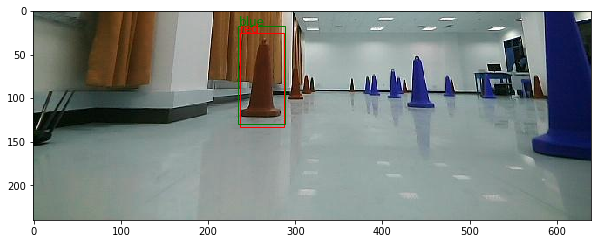

In [18]:
import time
import os
import json
import paddle
import paddle.fluid as fluid
from visualdl import LogWriter


ANCHORS_MASKS = [[6,7,8],[3,4,5],[0,1,2]]
VALID_THRESH = 0.01
NMS_TOPK = 400
NMS_POSK = 100
NMS_THRESH = 0.45


use = False
if use:
    TRAINDIR = 'insects/train'    
    TESTDIR = 'insects/val/images'
    VALIDDIR = 'insects/val'
    with fluid.dygraph.guard(place=fluid.CUDAPlace(0)):
        params_path = './out/model_epoch9'
        params_dict,opt_dict = fluid.load_dygraph(params_path)
        model = YOLOv3()
        model.load_dict(params_dict)
        model.eval()
        total_results = []
        test_loader = test_data_loader(TESTDIR,batch_size=1)
        for i,data in enumerate(test_loader()):
            img_name,img_data,img_scale_data = data
            img = to_variable(img_data)
            img_scale = to_variable(img_scale_data)
            outputs = model.forward(img)
            bboxes,scores = model.get_pred(outputs,im_shape=img_scale,anchors=ANCHORS,anchor_masks=ANCHORS_MASKS,valid_thresh=VALID_THRESH)
            bboxes_data = bboxes.numpy()
            scores_data = scores.numpy()
            results = multiclass_nms(bboxes_data,scores_data,score_thresh=VALID_THRESH,nms_thresh=NMS_THRESH,pre_nms_topk=NMS_TOPK,pos_nms_topk=NMS_TOPK)
            '''
            for j in range(len(result)):
                result_j = result[j]
                img_name_j = img_name[j]
                total_results.append([img_name_j,result_j.tolist()])
            json.dump(total_results,open('pred_results.json','w'))
            '''
result = results[0]
print(img_name)
draw_results(result,TESTDIR+'/'+img_name[0]+'.jpeg',draw_thresh=0.1)
        